# Gestión Moderna de Portafolio
### Autores: Bernardo León y Carlos Zapata
### Copyright 2022

## Capitulo 7: Evaluación de desempeño


In [2]:
#Librerías usadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy import stats
%pip install yfinance
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 971 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
# Información histórica dentro de muetsra (In-sample) para las acciones
fechai = "2015-12-01"
fechaf = "2020-12-31"
periodicidad = "1Mo"
activos = ["ADBE","MCD","MSCI","MSFT","NEE","PG","RSG","WMT"]
precios = yf.download(activos,start=fechai,end=fechaf,interval=periodicidad)['Adj Close'].dropna()
retornos = np.log(precios/precios.shift(1)).dropna()
mu = retornos.mean()
cov = retornos.cov()
var = np.diag(cov)
sigma = retornos.std()

[*********************100%***********************]  8 of 8 completed


In [4]:
indice = ["^GSPC"]
p_indice = yf.download(indice,start=fechai,end=fechaf,interval=periodicidad)['Adj Close'].dropna()
r_indice = np.log(p_indice/p_indice.shift(1)).dropna()
rpm = r_indice.mean()
sigmapm = r_indice.std()

[*********************100%***********************]  1 of 1 completed


In [5]:
# Información histórica fuera de muetsra (Out-sample) para las acciones
fechai_fm = "2020-12-01"
fechaf_fm = "2021-12-31"
periodicidad = "1Mo"
activos = ["ADBE","MCD","MSCI","MSFT","NEE","PG","RSG","WMT"]
precios_fm = yf.download(activos,start=fechai_fm,end=fechaf_fm,interval=periodicidad)['Adj Close'].dropna()
retornos_fm = np.log(precios_fm/precios_fm.shift(1)).dropna()
mu_fm = retornos_fm.mean()
cov_fm = retornos_fm.cov()
sigma_fm = retornos_fm.std()
n = len(mu)

[*********************100%***********************]  8 of 8 completed


In [6]:
indice = ["^GSPC"]
p_indice_fm = yf.download(indice,start=fechai_fm,end=fechaf_fm,interval=periodicidad)['Adj Close'].dropna()
r_indice_fm = np.log(p_indice_fm/p_indice_fm.shift(1)).dropna()
rpm_fm = r_indice_fm.mean()*12
sigmapm_fm = r_indice_fm.std()*np.sqrt(12)

[*********************100%***********************]  1 of 1 completed


# Ejemplo 7.1

In [73]:
# Tabla 7.1
datos = pd.concat([pd.DataFrame(mu*12,columns=['Retornos']),pd.DataFrame(sigma*np.sqrt(12),columns=['Volatilidades'])],axis=1).T
datos

,ADBE,MCD,MSCI,MSFT,NEE,PG,RSG,WMT
Retornos,0.334438,0.145223,0.376101,0.296015,0.243359,0.142153,0.177710,0.194796
Volatilidades,0.217030,0.169892,0.214384,0.179247,0.158507,0.141348,0.148402,0.174636


In [61]:
# Función para el PMVG
def pmvg(cov, ones):  
    covis = np.linalg.inv(cov)  
    w = np.dot(covis, ones)  
    return w / np.sum(np.abs(w)) 

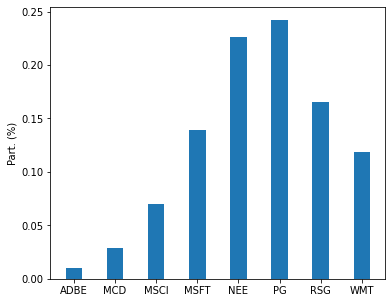

In [74]:
unos = np.repeat(1,n)
wpmvg = pmvg(cov, unos)

fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wpmvg, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

In [77]:
# Evaluacion de desempeño in-sample
# Retorno activo: 
rpmvg = wpmvg @ mu
Ramv = rpmvg - rpm
print('Ra: ', Ramv)

Ra:  0.007938277595646304


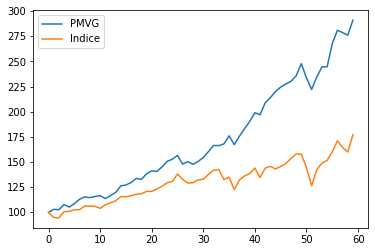

In [120]:
# Desempeño historico In-sample
valor = 100 
t = len(retornos)
n =len(mu)

# Retornos historicos
# PMVG
rhpmvg = retornos @ wpmvg

# Valor del portafolio
# PMV
port_mv = np.zeros((t))
port_mv[0] = valor
for i in range(1,t):
  port_mv[i] = port_mv[i-1]*np.exp(rhpmvg[i-1])
# Benchmark
port_benchmark = np.zeros((t))
port_benchmark[0] = valor
for i in range(1,t):
  port_benchmark[i] = port_benchmark[i-1]*np.exp(r_indice[i-1])

Performance = pd.concat([pd.DataFrame(port_mv,columns=['PMVG']), pd.DataFrame(port_benchmark,columns=['Indice'])], axis=1)
Performance.plot()

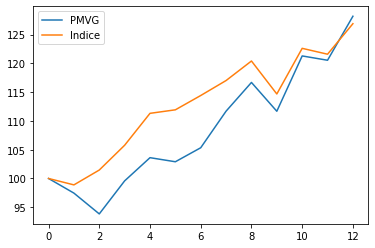

In [122]:
# Desempeño historico Out-sample
valor = 100 
t = len(retornos_fm)+1
n =len(mu)

# PMVG
rhpmvg_fm = retornos_fm @ wpmvg

# Valor del portafolio
# PMV
port_mv = np.zeros((t))
port_mv[0] = valor
for i in range(1,t):
  port_mv[i] = port_mv[i-1]*np.exp(rhpmvg_fm[i-1])
# Benchmark
port_benchmark = np.zeros((t))
port_benchmark[0] = valor
for i in range(1,t):
  port_benchmark[i] = port_benchmark[i-1]*np.exp(r_indice_fm[i-1])

Performance = pd.concat([pd.DataFrame(port_mv,columns=['PMVG']), pd.DataFrame(port_benchmark,columns=['Indice'])], axis=1)
Performance.plot()

## Ejemplo 7.2

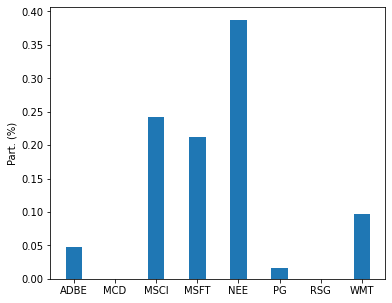

In [7]:
# Función para el PT
rf = 0.0
r = mu -rf 
n = len(mu)
# PT de Sharpe
w = cp.Variable(n)
risk = cp.quad_form(w, cov)
objective = cp.Minimize(risk)
constraints = [w @ r == 1, w >= 0] 
prob = cp.Problem(objective, constraints)
prob.solve()
wpt = w.value/np.sum(w.value)

fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wpt, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

In [175]:
# Evaluacion de desempeño in-sample
# Retorno activo: 
rpt = wpt @ mu
Ramv = rpt - rpm
print('Ra: ', Ramv)

Ra:  0.01356997366231278


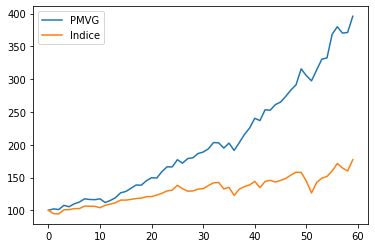

In [176]:
# Desempeño historico In-sample
valor = 100 
t = len(retornos)
n =len(mu)

# Retornos historicos
# PT
rhpt = retornos @ wpt

# Valor del portafolio
# PMV
port_t = np.zeros((t))
port_t[0] = valor
for i in range(1,t):
  port_t[i] = port_t[i-1]*np.exp(rhpt[i-1])
# Benchmark
port_benchmark = np.zeros((t))
port_benchmark[0] = valor
for i in range(1,t):
  port_benchmark[i] = port_benchmark[i-1]*np.exp(r_indice[i-1])

Performance = pd.concat([pd.DataFrame(port_t,columns=['PT']), pd.DataFrame(port_benchmark,columns=['Indice'])], axis=1)
Performance.plot()

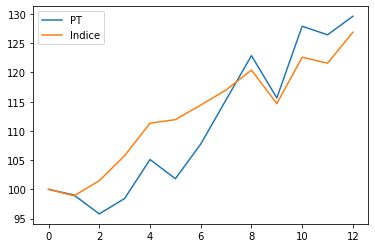

In [177]:
# Desempeño historico Out-sample
valor = 100 
t = len(retornos_fm)+1
n =len(mu)

# PT
rhpt_fm = retornos_fm @ wpt

# Valor del portafolio
# PT
port_t = np.zeros((t))
port_t[0] = valor
for i in range(1,t):
  port_t[i] = port_t[i-1]*np.exp(rhpt_fm[i-1])
# Benchmark
port_benchmark = np.zeros((t))
port_benchmark[0] = valor
for i in range(1,t):
  port_benchmark[i] = port_benchmark[i-1]*np.exp(r_indice_fm[i-1])

Performance = pd.concat([pd.DataFrame(port_t,columns=['PT']), pd.DataFrame(port_benchmark,columns=['Indice'])], axis=1)
Performance.plot()

### Ejemplo 7.3

In [14]:
# Formulación de Treynor

# Estimaciones: betas y varerror
t =len(retornos)
def linestim(x):
  return intercept + slope * x

betas = np.zeros((n,1))
varerror = np.zeros((n,1))

for i in range(n):
  slope, intercept, r, p, se = stats.linregress(r_indice, retornos.iloc[:,i])
  model = list(map(linestim, r_indice))
  betas[i] = slope
  varerror[i] = ((((retornos.iloc[:,i]-model)**2).sum())/(t-1))*12

# Cálculo coeficiente de Treynor
mu = np.array(mu).reshape((n,1))
betas = np.array(betas).reshape((n,1))
treynor = (mu-rf)/betas
estimaciones = np.matrix(np.concatenate([np.array(treynor).reshape((n,1)),np.array(mu).reshape((n,1)), 
                                      np.array(sigma).reshape((n,1)), np.array(betas).reshape((n,1)),
                                      np.array(varerror).reshape((n,1))],1))

tabla = pd.DataFrame(estimaciones)
tabla.columns=['Treynor','Retorno','Riesgo','Beta','VarError']
tabla.index=activos 
tabla_sort = tabla.sort_values(by=['Treynor'],ascending=False)
ratio1 = ((tabla_sort['Retorno']-rf)*tabla_sort['Beta'])/tabla_sort['VarError']
ratio2 = tabla_sort['Beta']**2/tabla_sort['VarError']

sumacu1 = ratio1.cumsum()
sumacu2 = ratio2.cumsum()
tasac = (sigmapm**2 * sumacu1)/(1+ sigmapm**2 * sumacu2)
cuttoff = tasac.max()
Zi = (tabla_sort['Beta']/tabla_sort['VarError'])*(tabla_sort['Treynor']-cuttoff)
Zi = Zi.mask(Zi<0, 0)
wpot = Zi/sum(Zi)

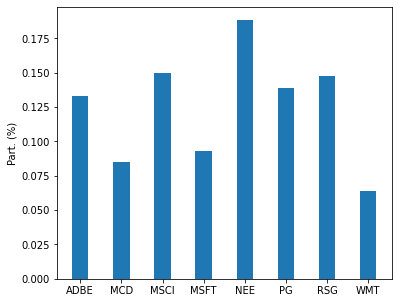

In [15]:
fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wpot, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

In [16]:
# Evaluacion de desempeño in-sample
# Retorno activo: 
rpot = wpot @ mu
Rapot = rpot - rpm
print('Ra: ', Rapot)

Ra:  [0.01028286]


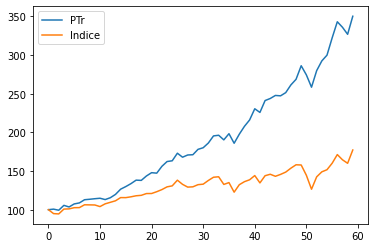

In [17]:
# Desempeño historico In-sample
valor = 100 
t = len(retornos)
n =len(mu)

# Retornos historicos
# PT
rhpot = retornos @ wpot

# Valor del portafolio
# PMV
port_ot = np.zeros((t))
port_ot[0] = valor
for i in range(1,t):
  port_ot[i] = port_ot[i-1]*np.exp(rhpot[i-1])
# Benchmark
port_benchmark = np.zeros((t))
port_benchmark[0] = valor
for i in range(1,t):
  port_benchmark[i] = port_benchmark[i-1]*np.exp(r_indice[i-1])

Performance = pd.concat([pd.DataFrame(port_ot,columns=['PTr']), pd.DataFrame(port_benchmark,columns=['Indice'])], axis=1)
Performance.plot()

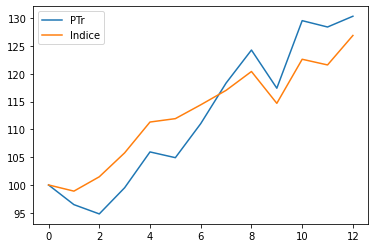

In [18]:
# Desempeño historico Out-sample
valor = 100 
t = len(retornos_fm)+1
n =len(mu)

# P Treynor
rhpot_fm = retornos_fm @ wpot

# Valor del portafolio
# P Treynor
port_ot = np.zeros((t))
port_ot[0] = valor
for i in range(1,t):
  port_ot[i] = port_ot[i-1]*np.exp(rhpot_fm[i-1])
# Benchmark
port_benchmark = np.zeros((t))
port_benchmark[0] = valor
for i in range(1,t):
  port_benchmark[i] = port_benchmark[i-1]*np.exp(r_indice_fm[i-1])

Performance = pd.concat([pd.DataFrame(port_ot,columns=['PTr']), pd.DataFrame(port_benchmark,columns=['Indice'])], axis=1)
Performance.plot()

### Ejemplo 7.4

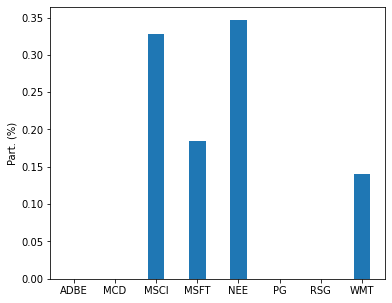

In [19]:
# Función para el PT
h = 0
rf = 0.0
r = mu -rf 
n = len(mu)

semiret = np.minimum(h, retornos)
semicov = semiret.cov()*12
semivar = np.diag(semicov)
semisigma = np.sqrt(semivar)

# PT de Sortino
w = cp.Variable(n)
risk = cp.quad_form(w, semicov)
objective = cp.Minimize(risk)
constraints = [w @ r == 1, w >= 0] 
prob = cp.Problem(objective, constraints)
prob.solve()
wps = w.value/np.sum(w.value)

fig = plt.figure(figsize = (6, 5))
plt.bar(activos, wps, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

In [20]:
# Evaluacion de desempeño in-sample
# Retorno activo: 
rps = wps @ mu
Raps = rps - rpm
print('Ra: ', Raps)

Ra:  [0.01400422]


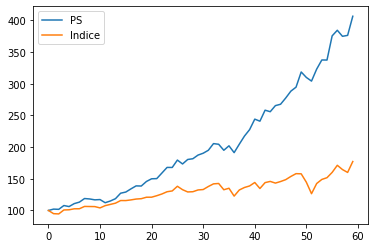

In [21]:
# Desempeño historico In-sample
valor = 100 
t = len(retornos)
n =len(mu)

# Retornos historicos
# P de Sortino
rhps = retornos @ wps

# Valor del portafolio
# P de Sortino
port_s = np.zeros((t))
port_s[0] = valor
for i in range(1,t):
  port_s[i] = port_s[i-1]*np.exp(rhps[i-1])
# Benchmark
port_benchmark = np.zeros((t))
port_benchmark[0] = valor
for i in range(1,t):
  port_benchmark[i] = port_benchmark[i-1]*np.exp(r_indice[i-1])

Performance = pd.concat([pd.DataFrame(port_s,columns=['PS']), pd.DataFrame(port_benchmark,columns=['Indice'])], axis=1)
Performance.plot()

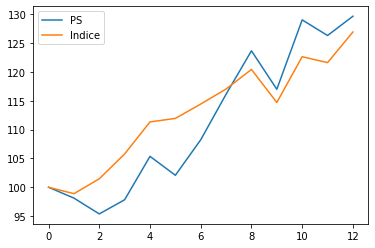

In [23]:
# Desempeño historico Out-sample
valor = 100 
t = len(retornos_fm)+1
n =len(mu)

# PSortino
rhps_fm = retornos_fm @ wps

# Valor del portafolio
# PSortino
port_s = np.zeros((t))
port_s[0] = valor
for i in range(1,t):
  port_s[i] = port_s[i-1]*np.exp(rhps_fm[i-1])
# Benchmark
port_benchmark = np.zeros((t))
port_benchmark[0] = valor
for i in range(1,t):
  port_benchmark[i] = port_benchmark[i-1]*np.exp(r_indice_fm[i-1])

Performance = pd.concat([pd.DataFrame(port_s,columns=['PS']), pd.DataFrame(port_benchmark,columns=['Indice'])], axis=1)
Performance.plot()